Sample multivariate-$t$ posteriors with frequentist-matching priors

In [2]:
import jax 
import jax.numpy as jnp 
import jax.random as jr
from jax.scipy.special import gammaln
import blackjax
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer
import pandas as pd
import tensorflow_probability.substrates.jax.distributions as tfd
from tqdm.notebook import trange

from utils import load_shear_experiment, make_df

key = jr.key(0)

(
    param_names,
    alpha, 
    fiducial_dv,
    covariance,
    Cinv,
    precision,
    derivatives,
    F, 
    Finv,
    lower,
    upper
) = load_shear_experiment()

n_data = fiducial_dv.size 
n_sims = 10000

parameter_prior = tfd.Blockwise(
    [
        tfd.Uniform(low=lower[p], high=upper[p]) 
        for p in range(alpha.size)
    ]
)

In [3]:
def linearized_model(_alpha, fiducial_dv, alpha, derivatives):
    return fiducial_dv + jnp.dot(_alpha - alpha, derivatives)


def t_logpdf(pi, data, shape, nu, m):
    # https://gregorygundersen.com/blog/2020/01/20/multivariate-t/    
    mean = linearized_model(pi, fiducial_dv, alpha, derivatives)

    dim = mean.size

    eigenvalues, eigenvectors = jnp.linalg.eigh(shape)
    logdet     = jnp.log(eigenvalues).sum()
    U          = eigenvectors * jnp.sqrt(1. / eigenvalues)
    dev        = data - mean
    maha       = jnp.square(jnp.dot(dev, U)).sum(axis=-1)

    t = 0.5 * (nu + dim)
    A = gammaln(t)
    B = gammaln(0.5 * nu)
    C = 0.5 * dim * np.log(nu * np.pi)
    D = 0.5 * logdet
    E = -0.5 * m * jnp.log(1. + (1. / nu) * maha) # This is df for shape matrix

    return A - B - C - D + E


def get_m(n_sims, n_data):
    # Eq 51 / 54 in Percival21
    B = (n_sims - n_data - 2) / ((n_sims - n_data - 1) * (n_sims - n_data - 4))
    m = alpha.size + 2 + (n_sims - 1 + B * (n_data - alpha.size)) / (1 + B * (n_data - alpha.size))
    return m


def dodelson(n_sims, n_data):
    # Dodelson factors
    B = (n_sims - n_data - 2.) / ((n_sims - n_data - 1.) * (n_sims - n_data - 4.))
    # Expansion-of-errors factor for likelihood with est. cov, data dimensional 
    return 1. + B * (n_data - alpha.size) 


def mle(d, Sinv):
    # Assuming accurate model + derivatives
    F_S = jnp.linalg.multi_dot([derivatives, Sinv, derivatives.T]) 
    Finv_S = jnp.linalg.inv(F_S)
    alpha_ = alpha + jnp.linalg.multi_dot([Finv_S, derivatives, Sinv, d - fiducial_dv])
    return alpha_

In [4]:
def inference_loop(rng_key, kernel, initial_state, num_samples):

    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jr.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jr.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jr.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


num_chains = 1
num_samples = 10_000

inv_mass_matrix = jnp.ones_like(alpha) * 0.1 # Length of this array = number of paramters
step_size = 1e-2

# Same keys for sampling
key, key_init, key_sample = jr.split(key, 3)

# Same initial positions for sampling
initial_positions = {
    "pi" : jr.multivariate_normal(key_init, alpha, Finv, (num_chains,))
}

Parameter prior for $t$-distribution posteriors is independent of covariance prior.

SH16 use $n_s$ for the index in their power law prior, meaning $m=n_s$.

In [5]:
def p21_logdensity(x, observed, S, n_sims): 
    # Posterior IJ-prior with exponent to give a t-distribution posterior with approximately frequentist coverage
    pi = x["pi"]
    return t_logpdf(
        pi, 
        data=observed, 
        shape=S, 
        nu=n_sims - 1, 
        m=get_m(n_sims, observed.size)
    ) + parameter_prior.log_prob(pi)


def sh16_logdensity(x, observed, S, n_sims): 
    # Posterior IJ-prior giving a t-distribution posterior
    pi = x["pi"]
    return t_logpdf(
        pi, 
        data=observed, 
        shape=S, 
        nu=n_sims - 1, 
        m=n_sims
    ) + parameter_prior.log_prob(pi)


def g_logdensity(x, observed, S, S_):
    # Posterior using Hartlap debiased data covariance (S_ is debiased precision)
    pi = x["pi"]
    mu = linearized_model(pi, fiducial_dv, alpha, derivatives)
    a, b = jnp.linalg.slogdet(2. * jnp.pi * S)
    logdet = a * b
    chi2 = jnp.linalg.multi_dot([observed - mu, S_, observed - mu])
    return -0.5 * (logdet + chi2) + parameter_prior.log_prob(pi)

In [6]:
# Number of simulations to estimate covariance with
n_sims_args = [500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000]

# Each datavector is a separate experiment with n_s simulations to calculate S
n_datavectors = 100

key, key_parameters, key_data = jr.split(key, 3)

# Sample parameters in parallel universes
parameters = parameter_prior.sample((n_datavectors,), seed=key_parameters)
models = jax.vmap(lambda pi: linearized_model(pi, fiducial_dv, alpha, derivatives))(parameters)

# Sample independent datavectors
datavectors = jr.multivariate_normal(
    key_data, models, covariance, (n_datavectors,)
)

SAMPLES = np.zeros((len(n_sims_args), n_datavectors, num_samples, alpha.size))
PROBS = np.zeros((len(n_sims_args), n_datavectors, num_samples))
MLES = np.zeros((len(n_sims_args), n_datavectors, alpha.size))
C = np.zeros((len(n_sims_args), n_datavectors))
with trange(len(n_sims_args)) as bar:
    for n, n_s in zip(bar, n_sims_args):
        for i in range(n_datavectors):

            # Estimate covariance
            key, key_init, key_S = jr.split(key, 3)
            fiducials = jr.multivariate_normal(key_S, fiducial_dv, covariance, (n_s,))
            S = jnp.cov(fiducials.T)

            # Multivariate-t distribution with frequentist-matching prior, given datavector and estimated covariance
            logdensity_fn = lambda pi: p21_logdensity(pi, observed=datavectors[i], S=S, n_sims=n_s)

            # Initialise MCMC on posterior function
            nuts = blackjax.nuts(logdensity_fn, step_size, inv_mass_matrix)
            nuts_kernel = jax.jit(nuts.step)

            # Same initial positions for sampling
            initial_positions = {
                "pi" : jr.multivariate_normal(key_init, parameters[i], Finv, (num_chains,))
            }
            initial_states = jax.vmap(nuts.init)(initial_positions)

            # Sample posterior given datavector (same sampling key)
            states = inference_loop_multiple_chains(
                key_sample, 
                jax.jit(nuts.step), 
                initial_states, 
                num_samples, 
                num_chains 
            )

            # Are true parameters recovered by true posterior?
            coverage = jnp.mean(logdensity_fn(dict(pi=parameters[i])) > states.logdensity)

            C[n, i] = coverage
            SAMPLES[n, i] = states.position["pi"].block_until_ready().squeeze()
            PROBS[n, i] = states.logdensity.squeeze()
            MLES[n, i] = mle(datavectors[i], jnp.linalg.inv(S))
            bar.set_postfix_str(f"{n_s=} {i=}")

  0%|          | 0/11 [00:00<?, ?it/s]

2024-07-19 21:51:30.591718: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17m2.735983s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-19 22:52:38.198802: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17m24.483866s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-20 07:33:57.052441: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 16m21.03988s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-2

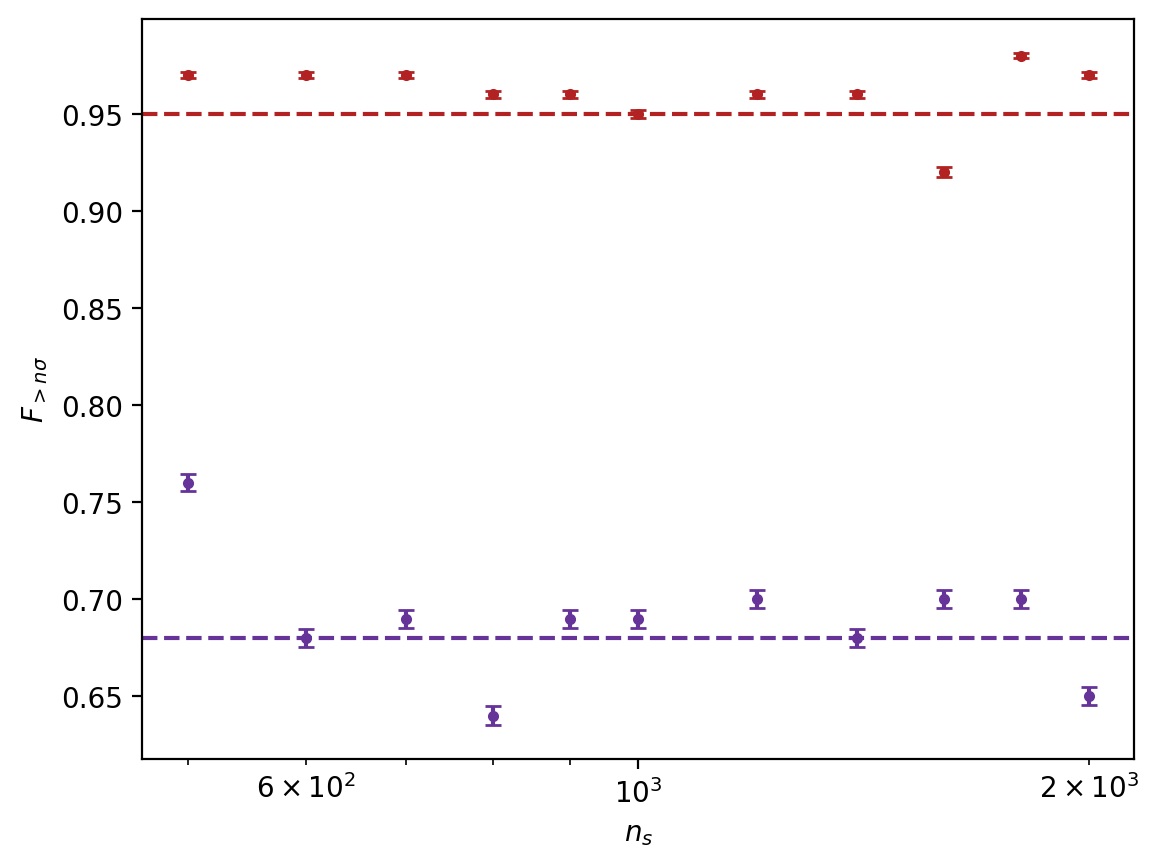

In [20]:
F1 = C > 1. - 0.68
F2 = C > 1. - 0.95

err_kwargs = dict(linestyle="", capsize=3, marker=".")

plt.figure(dpi=200)
line = plt.errorbar(
    n_sims_args, 
    F1.mean(axis=1), 
    yerr=F1.std(axis=1) / n_datavectors, 
    color="rebeccapurple",
    **err_kwargs
)
plt.axhline(0.68, linestyle="--", color="rebeccapurple")
plt.errorbar(
    n_sims_args, 
    F2.mean(axis=1), 
    yerr=F2.std(axis=1) / n_datavectors, 
    color="firebrick",
    **err_kwargs
)
plt.axhline(0.95, linestyle="--", color="firebrick")
plt.xlabel(r"$n_s$")
plt.ylabel(r"$F_{>n\sigma}$")
plt.xscale("log")
plt.show()

In [8]:
jnp.isfinite(SAMPLES).all(), jnp.isfinite(PROBS).all()

(Array(True, dtype=bool), Array(False, dtype=bool))

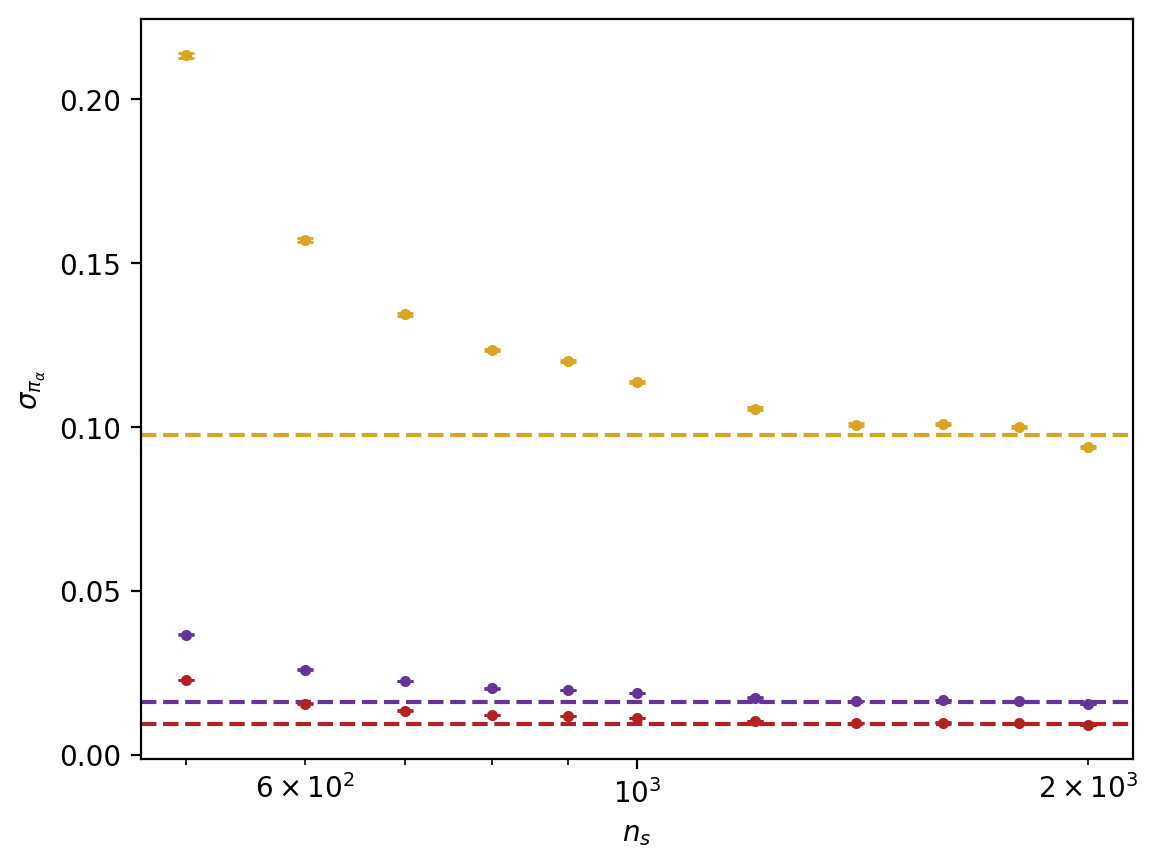

In [9]:
param_colors = ["firebrick", "rebeccapurple", "goldenrod"]

plt.figure(dpi=200)

for p in range(alpha.size):
    plt.errorbar(
        n_sims_args, 
        SAMPLES[..., p].std(axis=2).mean(axis=1), 
        yerr=SAMPLES[..., p].std(axis=2).std(axis=1) / n_datavectors,
        color=param_colors[p],
        marker=".",
        linestyle="",
        capsize=3
    )
    plt.axhline(jnp.sqrt(jnp.diag(Finv))[p], color=param_colors[p], linestyle="--")
plt.xlabel(r"$n_s$")
plt.ylabel(r"$\sigma_{\pi_{\alpha}}$")
plt.xscale("log")
plt.show()

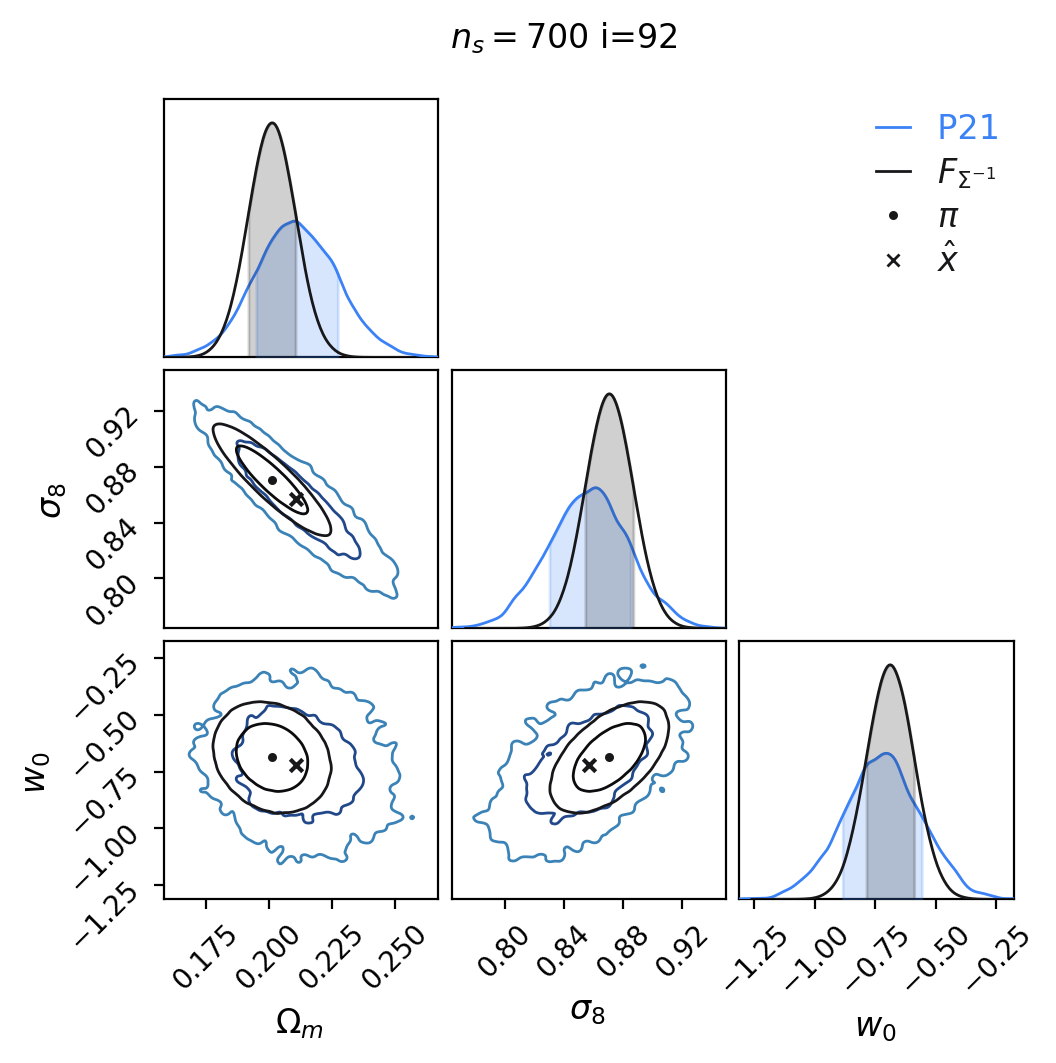

In [19]:
c = ChainConsumer()

n = np.random.randint(0, len(n_sims_args))
i = np.random.randint(0, n_datavectors)
samples, log_pdfs = SAMPLES[n, i], PROBS[n, i]

posterior_df = make_df(samples, log_pdfs, param_names)

c.add_chain(Chain(samples=posterior_df, name="P21", shade_alpha=0.))

c.add_chain(
    Chain.from_covariance(
        parameters[i],
        Finv,
        columns=param_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)

c.add_marker(location=dict(zip(param_names, np.asarray(parameters[i]))), name=r"$\pi$", color="k")
c.add_marker(location=dict(zip(param_names, MLES[n, i])), name=r"$\hat{x}$", color="k", marker_style="x")

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figwidth(5.)
fig.set_figheight(5.)
fig.suptitle(fr"$n_s={n_sims_args[n]}$ {i=}")
plt.savefig("posteriors.png")
plt.show()